In [1]:
#import modules
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import pims
import trackpy as tp
import os

#MatPlotLib
import matplotlib as mpl
import matplotlib.pyplot as plt

#Scikit-image
from skimage.transform import rotate
from skimage.util import crop
from skimage import exposure
from skimage import data, img_as_float, img_as_uint

#magic commands
%matplotlib inline 
%matplotlib notebook

#tweak styles
mpl.rc('figure', figsize = (10,6))
mpl.rc('image', cmap = 'gray')

#get some DeprecationWarnings in sklearn module. Ignore these warnings for now.
import warnings
warnings.filterwarnings('ignore')

SUPPORT FUNCTIONS

In [59]:
def adapthist(im):
    """
    Enhance contrast by adaptive histogram equalization
    """
    
    im_adapteq = exposure.equalize_adapthist(im, clip_limit=0.01)
    
    return im_adapteq

def showim2(im1, im2):
    """
    Show two images side-by-side
    """
    #Show images
    f, ax = plt.subplots(1, 2, sharey=True)
    plt.axes(ax[0])
    plt.imshow(im1)
    plt.axes(ax[1])
    plt.imshow(im2)
    
def partparms(trajectory):
    """
    IN: trajs OUT: np.array(particle#, diag_size, total_dist, mean_vel)
    """
    #store particle numbers
    partnumbers = trajectory['particle'].unique()
    
    #create empty output array
    p_partparms = np.array([[],[],[],[]]).T
    
    for p in partnumbers:
        
        #filter single particle trajectory and sort by frame number
        trajectory_p = pd.DataFrame(trajectory[trajectory['particle'] == p].sort_values(['frame'], ascending=True))

        #create empty 2-d arry for each particle with [distance,velocity]
        dist_vel = np.array([[],[]]).T
        
        for obs in range(1,len(trajectory_p)):
        
            r0 = np.array([trajectory_p.iloc[obs-1,0], trajectory_p.iloc[obs-1,1]])
            r1 = np.array([trajectory_p.iloc[obs,0], trajectory_p.iloc[obs,1]])
            t = trajectory_p.iloc[obs]['frame'] - trajectory_p.iloc[obs-1]['frame']
            dist = np.linalg.norm(r1-r0)
            vel = dist/t
            dist_vel = np.append(dist_vel,[[dist,vel]], axis = 0)

        #calculate trajectory parameters for each particle
        total_dist = np.sum(dist_vel, axis = 0)[0]
        mean_vel = np.mean(dist_vel, axis =0)[1]
        diag_size = tp.diagonal_size(trajectory_p)
        
        p_partparms = np.append(p_partparms, [[p, diag_size, total_dist, mean_vel]], axis=0)
        
    print('Extracted ',p_dist_vel.shape[0] ,'trajectories.')    
    return(p_partparms)


LOAD DATA

In [3]:
filedir = 'D:\\Dropbox\\D_PROGRAMMING\\PYTHON\\BLOODFLOW\\BLOODFLOWDATA'
filename = 'H160122-X10-TAILEND3-FL80FPS.tif'
file = os.path.join(filedir, filename)
#frames = pims.TiffStack(file)
frames = pims.TiffStack(file, process_func=adapthist)
#metadata
metadatastring = frames[0].metadata['ImageDescription']

LOCATE FEATURES

<IPython.core.display.Javascript object>


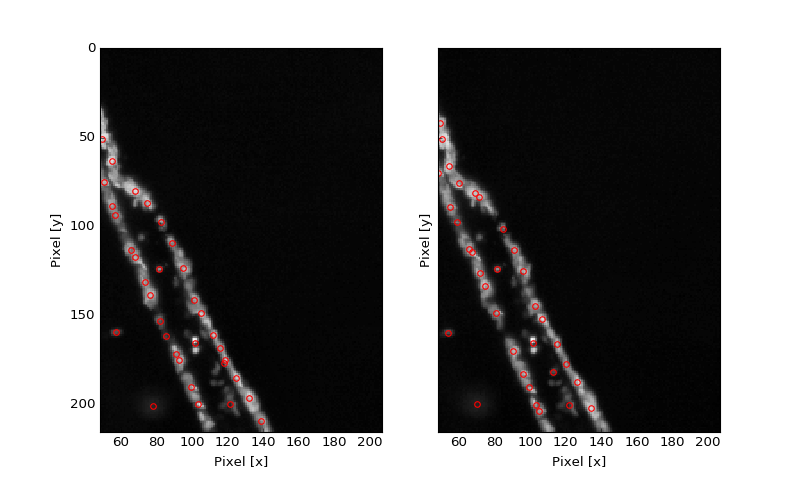

[None, None]

In [10]:
#Locate features
fnumber = 50 #current frame to look at
diam = 11 #odd integer with features extent in pixels
minm = 0.03 #minimum integrated brightness
sep = 1 #minimum separation between features
perc = 20 #features must have a peak brighter than pixels in this percentile
topnum = 500 #return only the N brightest features above minmass

feats1 = tp.locate(frames[fnumber], invert=False, diameter=diam, minmass=minm, separation=sep, percentile=perc,
                  topn=topnum)
feats2 = tp.locate(frames[fnumber+10], invert=False, diameter=diam, minmass=minm, separation=sep, percentile=perc,
                  topn=topnum)

f, ax = plt.subplots(1, 2, sharey=True)
plt.axes(ax[0])
tp.annotate(feats1, frames[fnumber], plot_style={'markersize':5, 'markeredgewidth':1})

plt.axes(ax[1])
tp.annotate(feats2, frames[fnumber+10], plot_style={'markersize':5, 'markeredgewidth':1})

#set axis properties
[ax[i].set_xlabel('Pixel [x]') for i in range(2)]
[ax[i].set_ylabel('Pixel [y]') for i in range(2)]
[ax[i].legend_.remove() for i in range(2)]

SOME FEATURE DIAGNOSTICS

<IPython.core.display.Javascript object>


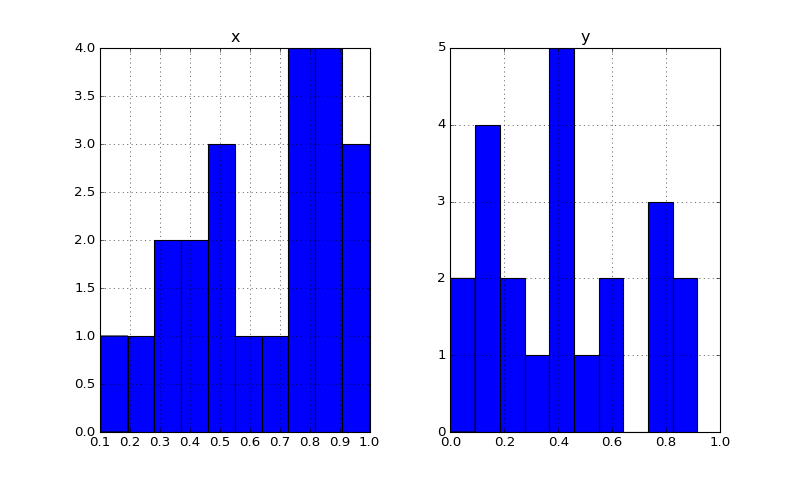

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000C0F9BA6160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000C0FA1AAB00>]], dtype=object)

In [13]:
tp.subpx_bias(feats1)

FIND FEATURES IN ALL FRAMES

In [11]:
feats = tp.batch(frames, diameter=diam, minmass=minm, separation=sep, invert=False, percentile=perc,
                 topn=topnum)

Frame 499: 49 features


LINK FEATURES INTO PARTICLE TRAJECTORIES

In [12]:
searchrange = 5 #Maximum distance features can move between frames
memory = 3 #Maximum number of frames during which a feature can vanish, than reappear and consider the same particle
trajs = tp.link_df(feats, 5, memory=3)

Frame 499: 49 trajectories present


FILTER TRAJECTORIES

In [13]:
#get rid of spurious trajectories (minimum number of frames)
trajsF1 = tp.filter_stubs(trajs, threshold = 20)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', trajs['particle'].nunique())
print('After:', trajsF1['particle'].nunique())

Before: 1010
After: 351


In [18]:
trajsF1[1:10]

,x,y,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
1,45.356463,19.043089,3.763290,2.398237,0.181321,0.176898,6.580415,0.029164,1,0
2,45.001581,18.413593,3.869817,2.394893,0.191964,0.183500,6.579499,0.027663,2,0
3,44.607595,17.829114,3.904939,2.425254,0.207085,0.183301,6.649226,0.028352,3,0
4,44.235653,17.150838,3.950502,2.404816,0.190738,0.188597,6.781666,0.028386,4,0
5,43.959431,16.638040,3.798232,2.407838,0.185392,0.180106,6.515295,0.027805,5,0
6,43.682252,15.988073,4.050803,2.421772,0.191435,0.189398,6.901572,0.027582,6,0
7,43.449782,15.355653,3.902142,2.430399,0.190663,0.181759,6.898925,0.029015,7,0
8,43.242007,14.926217,3.749349,2.393835,0.178023,0.177047,6.702832,0.030996,8,0
9,43.001544,14.354606,3.626217,2.365040,0.172108,0.177298,6.642414,0.030054,9,0


<IPython.core.display.Javascript object>


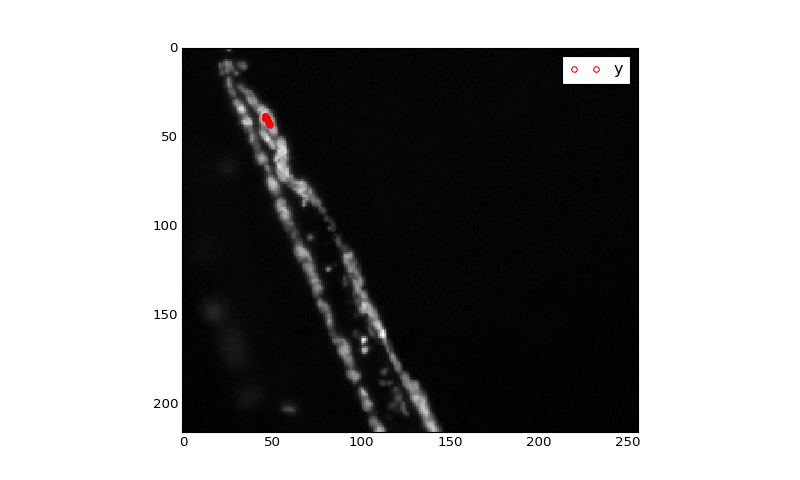

In [14]:
#identify particle numbers left in data
partnums = trajsF1['particle'].unique()
#plot particle track across image
featnum = 2 #particle number
plt.figure()
tp.annotate(trajsF1[trajsF1['particle'] == partnums[featnum]], frames[0], 
            plot_style={'markersize':5, 'markeredgewidth':1})

<IPython.core.display.Javascript object>


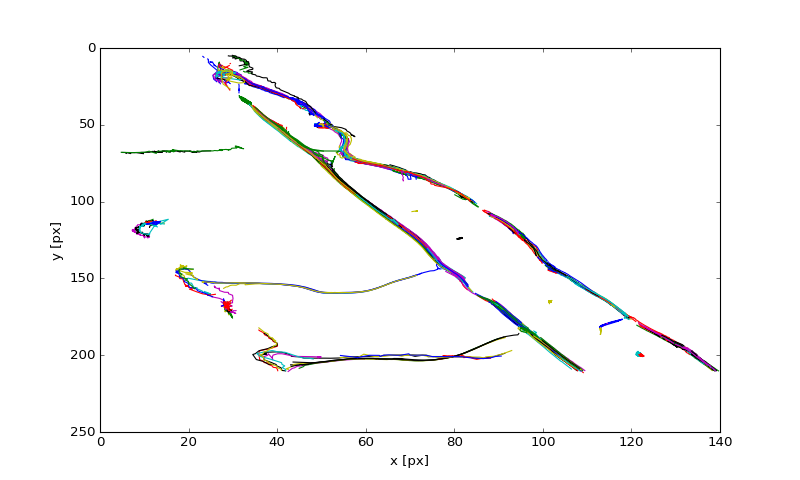

In [15]:
#plot trajectories
plt.figure()
tp.plot_traj(trajsF1)
plt.gca().legend_.remove()

In [63]:
#Our goal: a histogram of the trajectory lengths
#and then, filter the particles that have the longest trajetories
#calculate distances and velocities for each particle
p_parms = partparms(trajsF1) #OUT: np.array(particle#, diag_size, total_dist, mean_vel)

Extracted  351 trajectories.


<IPython.core.display.Javascript object>


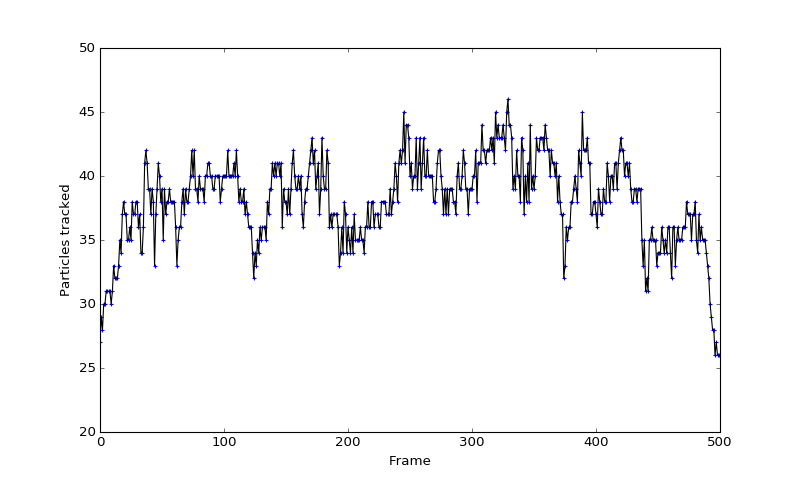

<IPython.core.display.Javascript object>


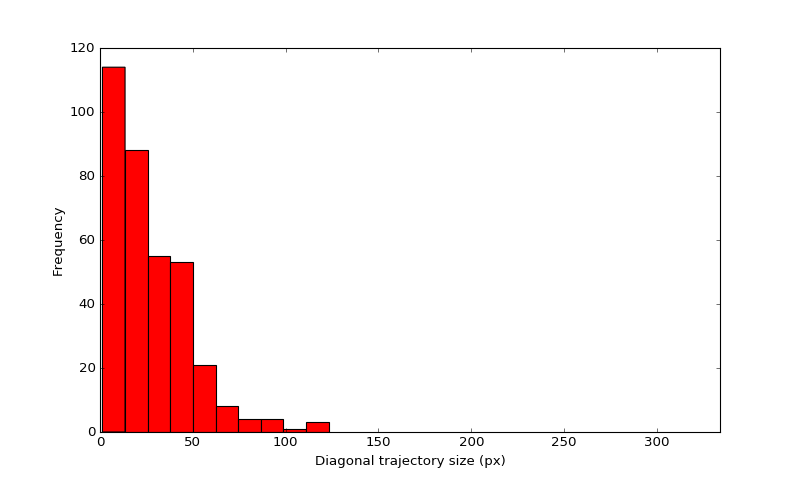

<IPython.core.display.Javascript object>


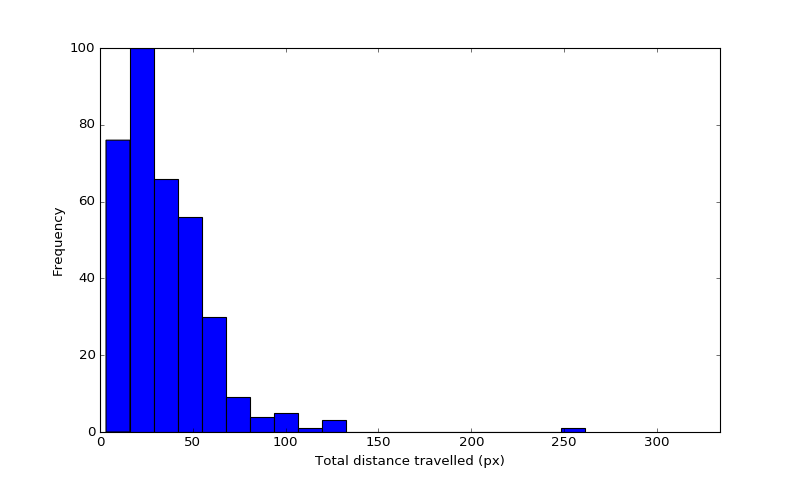

<IPython.core.display.Javascript object>


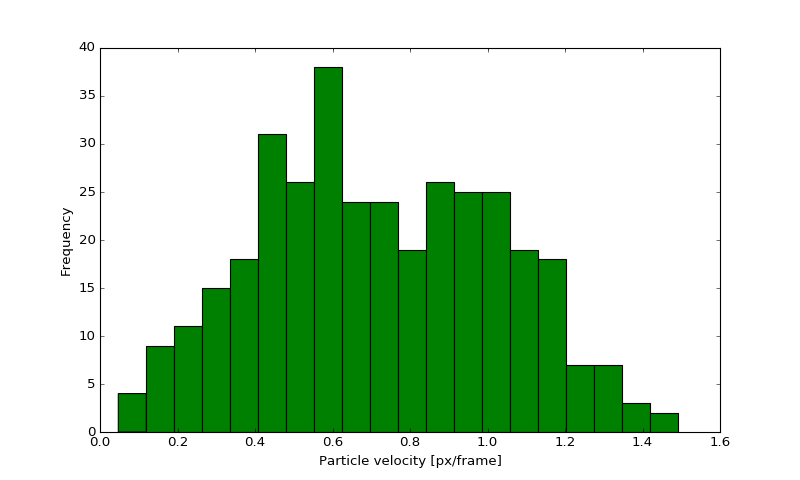

In [140]:
#particle tracking statistics

#Number of tracked blood cells per frame
plt.figure('Number of blood cells tracked per frame')
ax0=plt.axes()
ax0.scatter(x=fx, y=PartPerFrame, s=20, marker='+', linewidths=1)
PartPerFrame = np.array([trajsF1[trajsF1['frame']==i].shape[0] for i in range(0,len(frames))])
fx = np.array(range(0,len(frames)))
PartLine = mpl.lines.Line2D(xdata=fx,ydata=PartPerFrame, linewidth=1, color='black')
ax0.add_line(PartLine)
ax0.axis(xmin=0, xmax=len(frames))
ax0.set_xlabel('Frame')
ax0.set_ylabel('Particles tracked')

#hist: Diagonal trajectory size
plt.figure('Diagonal trajectory sizes')
ax1=plt.axes()
maxdist = np.floor(np.linalg.norm(frames[0].shape)) # diagonal image size
ax1.hist(p_parms[:,1], histtype='bar', color='red', bins=10)
ax1.axis(xmin=0, xmax=maxdist)
ax1.set_xlabel('Diagonal trajectory size (px)')
ax1.set_ylabel('Frequency')

#hist: Total distance travelled
plt.figure('Total distance tracked')
ax2=plt.axes()
ax2.hist(p_parms[:,2], histtype='bar', color='blue', bins=20)
ax2.axis(xmin=0, xmax=maxdist)
ax2.set_xlabel('Total distance travelled (px)')
ax2.set_ylabel('Frequency')

#hist Mean particle velocity
plt.figure('Mean particle velocity')
ax3=plt.axes()
ax3.hist(p_parms[:,3], histtype='bar', color='green', bins=20)
#ax3.axis(xmin=0, xmax=2)
ax3.set_xticks(np.arange(0,1.5,0.2), minor=True)
ax3.set_xlabel('Particle velocity [px/frame]')
ax3.set_ylabel('Frequency')

#Particle velocity as a function of distance travelled
#Does the tracked distance matter for the velocity calculation?




In [135]:
np.arange(0,2,0.5)

array([ 0. ,  0.5,  1. ,  1.5])